In [19]:
!pip install leidenalg
!pip install python-igraph

In [20]:
import os
import glob
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
from networkx.algorithms.community import modularity
from collections import defaultdict
from sklearn.metrics import adjusted_rand_score
import igraph as ig
import leidenalg
import matplotlib.cm as cm
import numpy as np
import time

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
competition_path = "/content/drive/MyDrive/SNARS/competition"

graphs = []

pattern = os.path.join(competition_path, "D*-*.csv")

for path in glob.glob(pattern):
    filename = os.path.basename(path)

    match = re.match(r"D(\d+)-(UNC|K=(\d+))\.csv", filename)
    if match:
        id = int(match.group(1))
        k = match.group(3)  # None jeśli UNC
        k = int(k) if k is not None else None

        A = pd.read_csv(path, header=None).values
        G = nx.from_numpy_array(A)

        graphs.append({
            "id": id,
            "k": k,
            "graph": G,
            "file": filename
        })

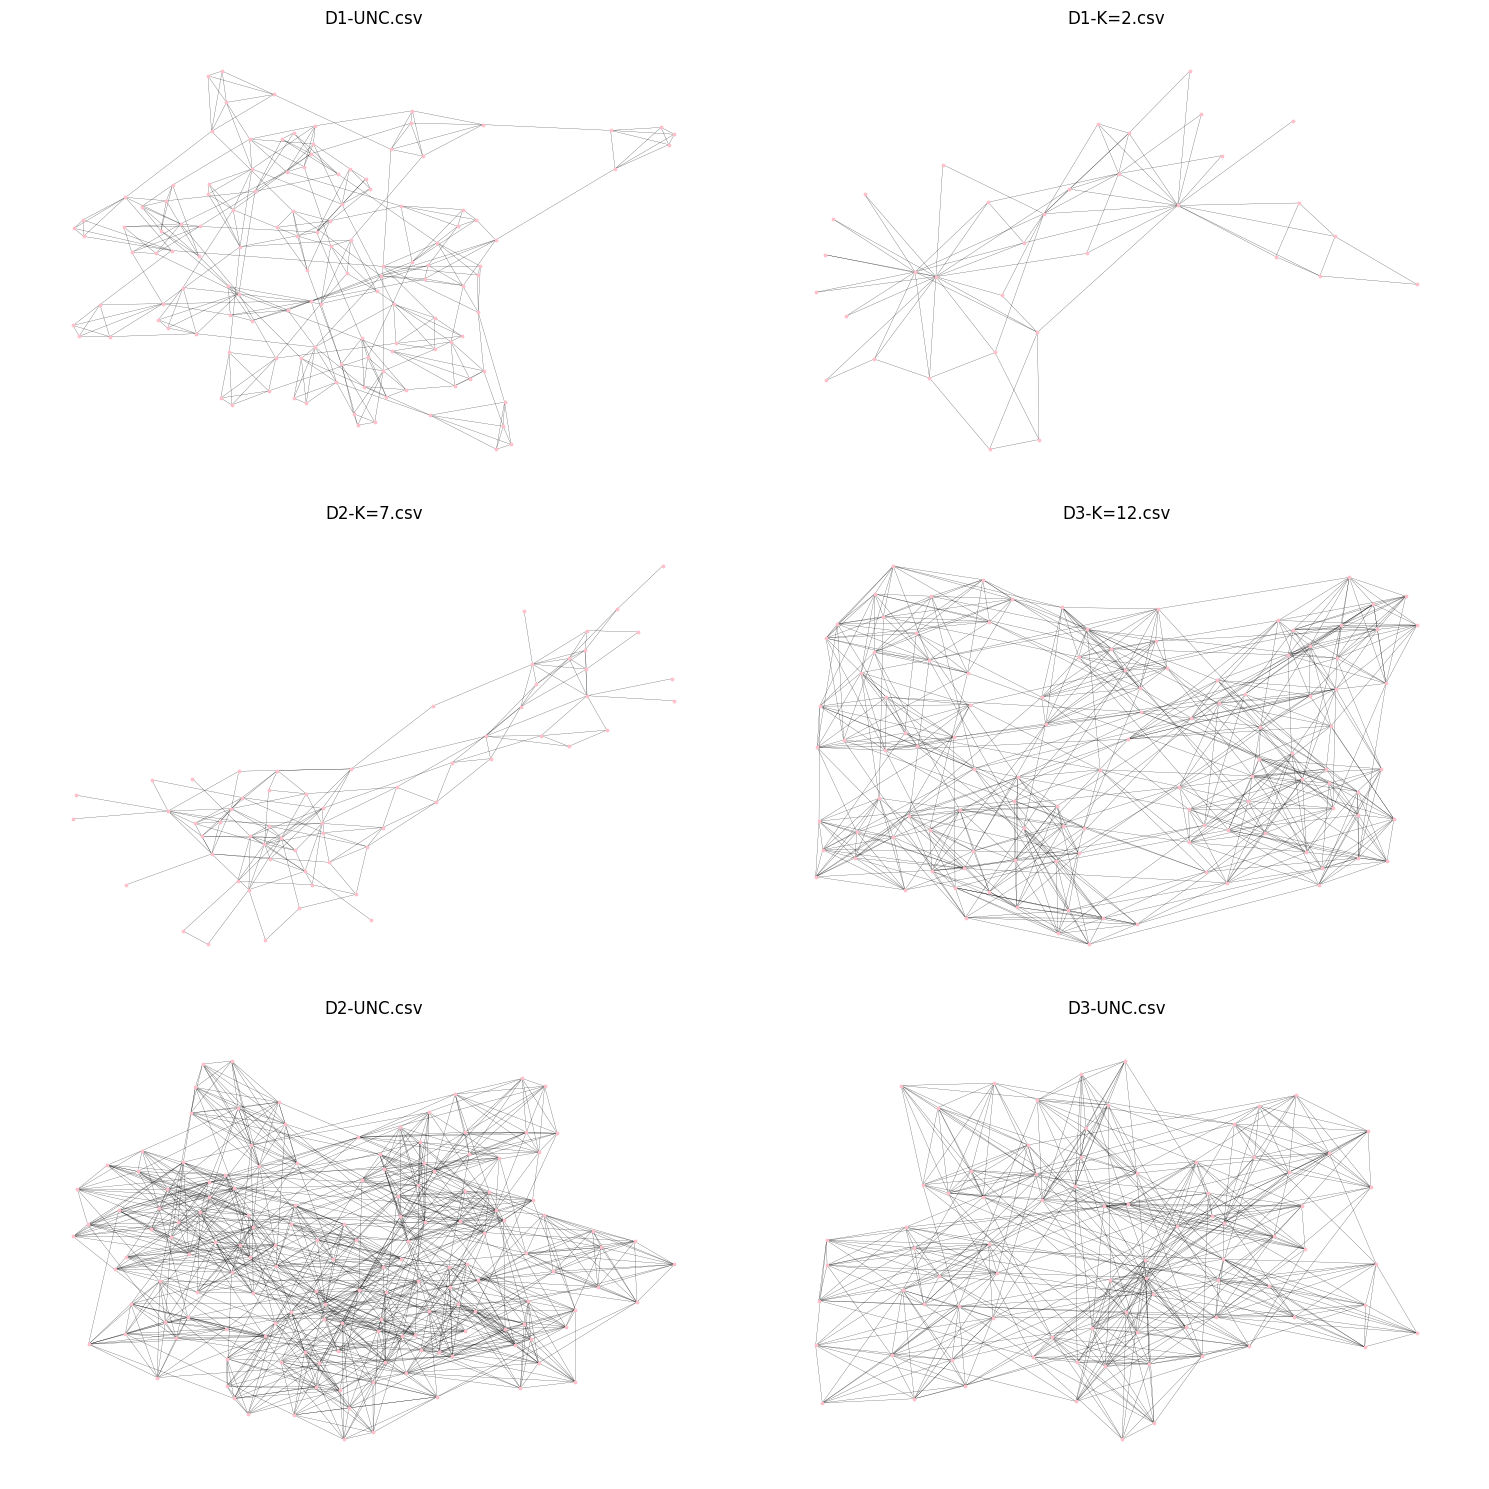

In [23]:
plot_options = {"with_labels": False, "width": 0.15, "node_size": 3}

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for idx, g in enumerate(graphs):
    graph = g["graph"]
    file = g["file"]

    pos = nx.spring_layout(graph, seed=42)

    ax = axes[idx]
    ax.axis("off")

    nx.draw_networkx(
        graph,
        pos=pos,
        node_color="pink",
        ax=ax,
        **plot_options
    )

    ax.set_title(file)

plt.tight_layout()
plt.show()

**Optimization-Based Community Detection Methods - Leiden**

Community detection can be formulated as an optimization problem, where the goal is to find a partition of a network that maximizes a quality function over all possible partitions. One of the most widely used quality functions is *modularity* which measures how much the density of edges inside communities exceeds the expected density in a suitable random (null-model) network.

The general definition of modularity is given by
\begin{equation}
Q = \frac{1}{2N} \sum_{ij} \left( A_{ij} - P_{ij} \right)\delta(C_i, C_j),
\end{equation}
where:
* $N$ is the total number of edges in the network,
* $A_{ij}$ is the adjacency matrix,
* $P_{ij}$ is the expected number of edges between vertices $i$ and $j$ in the null model,
* $\delta(C_i, C_j)$ is the Kronecker delta.

The most common choice of the null model is the configuration model, for which
\begin{equation}
P_{ij} = \frac{k_i k_j}{2N},
\end{equation}
where $k_i$ denotes the degree of vertex $i$.

Substituting this expression into the definition of modularity yields its classical form:
\begin{equation}
Q = \frac{1}{2N} \sum_{ij} \left( A_{ij} - \frac{k_i k_j}{2N} \right)\delta(C_i, C_j).
\end{equation}

Since only pairs of vertices belonging to the same community contribute to the sum, modularity can also be rewritten as:
\begin{equation}
Q = \sum_{C} \left[ \frac{l_C}{N} - \left( \frac{k_C}{2N} \right)^2 \right],
\end{equation}
where:
* $l_C$ is the number of edges inside community $C$,
* $k_C$ is the sum of degrees of the vertices in $C$.

The first term represents the observed fraction of internal edges, while the second term corresponds to the expected fraction under the null model.

Maximizing modularity is an NP-hard problem, therefore in practice only heuristic algorithms are used. Modularity also suffers from a known limitation called the *resolution limit*, which may lead to merging small communities or splitting large ones due to its global null model.

The Louvain algorithm applies a fast greedy optimization of modularity but may produce poorly connected communities. The Leiden algorithm improves Louvain by ensuring internally connected communities and more reliable convergence while optimizing the same objective function. For this reason, Leiden is used as the final community detection method in this work.

The Leiden algorithm was applied using the reference implementation available in the `leidenalg` Python library, with graphs represented using the `igraph` framework.

In [24]:
def nx_to_igraph(G):
    return ig.Graph.from_networkx(G)

In [25]:
def leiden_partition(G):
    G_ig = nx_to_igraph(G)
    partition = leidenalg.find_partition(
        G_ig,
        leidenalg.ModularityVertexPartition
    )
    return partition.membership

In [26]:
def labels_to_communities(labels):
    comms = defaultdict(set)
    for i, c in enumerate(labels):
        comms[c].add(i)
    return list(comms.values())

In [27]:
# test
sizes = [20,20,20,20]
probs = [[0.3, 0.01, 0.01, 0.01],
        [0.01, 0.3, 0.01, 0.01],
         [0.01, 0.01, 0.3, 0.01],
          [0.01, 0.01, 0.01, 0.3]]
G = nx.stochastic_block_model(sizes, probs)
labels = leiden_partition(G)
communities = labels_to_communities(labels)
print("Number of communities:", len(communities))
print(communities)

Number of communities: 4
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}, {20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}, {40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59}, {60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79}]


In [28]:
def run_leiden_on_graph(G):
    labels = leiden_partition(G)
    communities = labels_to_communities(labels)
    Q = modularity(G, communities)

    sizes = [len(c) for c in communities]

    return {
        "n_nodes": G.number_of_nodes(),
        "n_edges": G.number_of_edges(),
        "n_communities": len(communities),
        "community_sizes": sizes,
        "modularity": Q
    }

In [29]:
results = []

for g in graphs:
    G = g["graph"]
    res = run_leiden_on_graph(G)

    res["graph_id"] = g["id"]
    res["file"] = g["file"]
    res["k_given"] = g["k"]  # None dla UNC

    results.append(res)
for r in results:
    print(
        f'{r["file"]}: '
        f'{r["n_communities"]} communities, '
        f'Q={r["modularity"]:.3f}, '
        f'sizes={r["community_sizes"]}'
    )

D1-UNC.csv: 15 communities, Q=0.724, sizes=[10, 5, 5, 5, 10, 15, 15, 10, 10, 10, 5, 5, 10, 5, 5]
D1-K=2.csv: 4 communities, Q=0.419, sizes=[12, 5, 11, 6]
D2-K=7.csv: 6 communities, Q=0.520, sizes=[7, 8, 5, 12, 14, 16]
D3-K=12.csv: 10 communities, Q=0.605, sizes=[10, 9, 9, 15, 16, 11, 14, 10, 12, 9]
D2-UNC.csv: 15 communities, Q=0.651, sizes=[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
D3-UNC.csv: 9 communities, Q=0.552, sizes=[9, 9, 9, 9, 9, 9, 9, 9, 9]


In [30]:
def leiden_stability(G, n_runs=5):
    runs = []
    for _ in range(n_runs):
        labels = leiden_partition(G)
        runs.append(labels)

    ari_vals = []
    for i in range(n_runs):
        for j in range(i+1, n_runs):
            ari_vals.append(adjusted_rand_score(runs[i], runs[j]))

    return sum(ari_vals) / len(ari_vals)

print("Mean ARI:", leiden_stability(graphs[0]["graph"]))
# The obtained partitions were fully stable across multiple runs, yielding identical results in all cases.

Mean ARI: 1.0


/tmp/ipython-input-4053909981.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", n_comms)


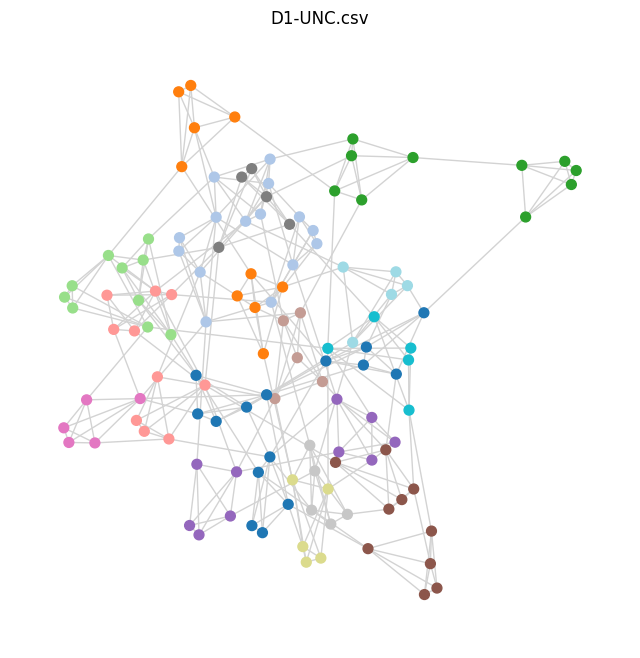

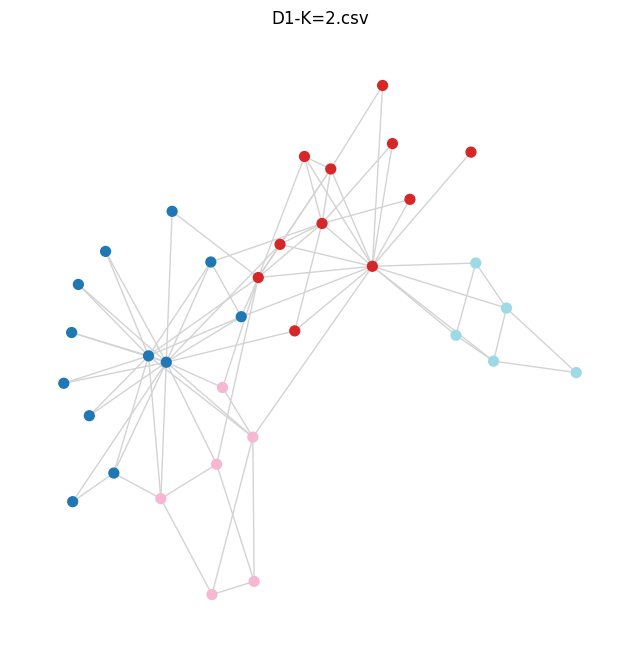

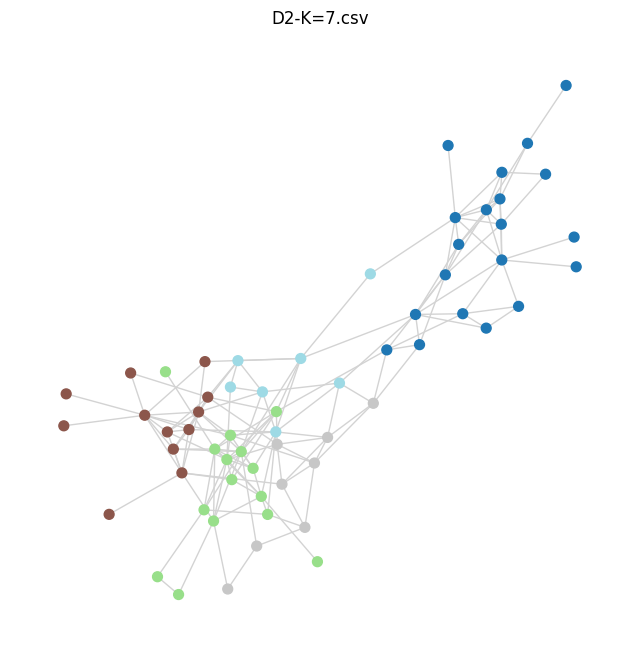

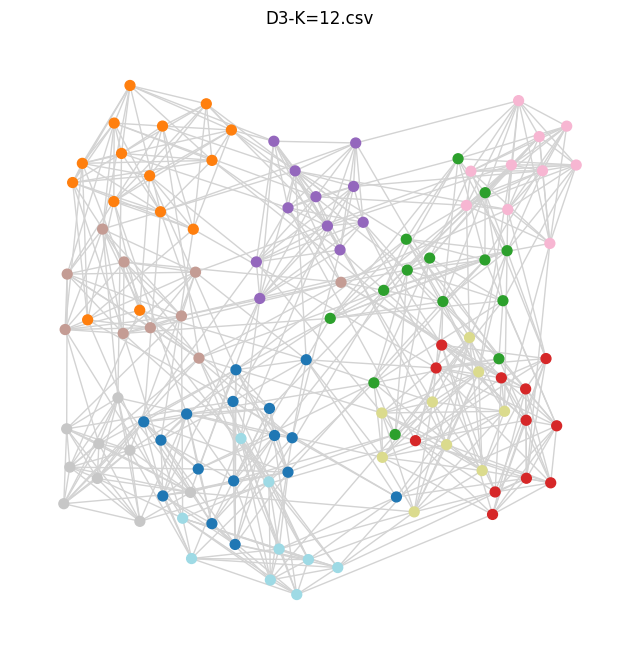

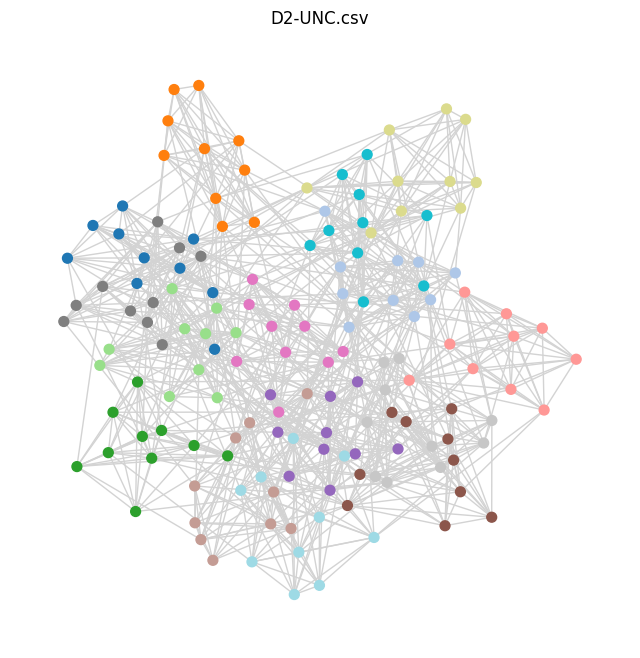

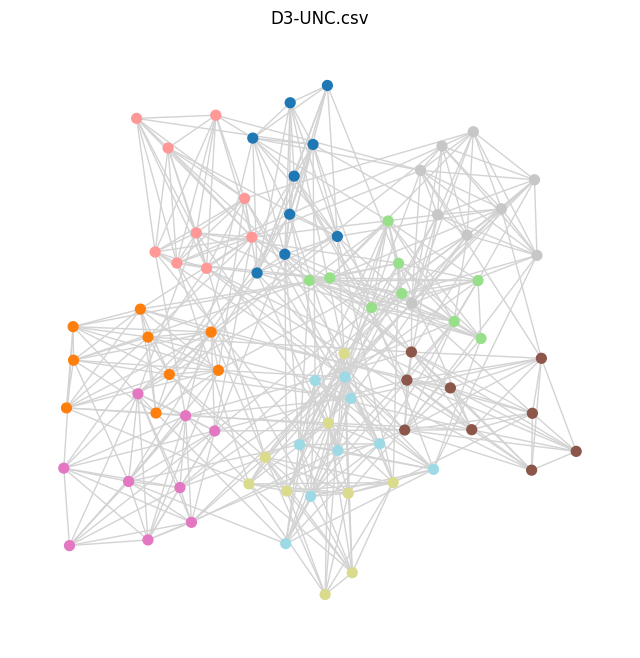

In [31]:
def draw_communities(G, labels, title=None):
    pos = nx.spring_layout(G, seed=42)

    labels = np.array(labels)
    n_comms = len(set(labels))
    cmap = cm.get_cmap("tab20", n_comms)

    node_colors = [cmap(labels[i]) for i in G.nodes()]

    plt.figure(figsize=(8, 8))
    nx.draw_networkx(
        G,
        pos=pos,
        node_color=node_colors,
        node_size=50,
        with_labels=False,
        edge_color="lightgray"
    )
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

execution_times = []

for g in graphs:
    G = g["graph"]
    filename = g["file"]

    start_time = time.time()

    labels = leiden_partition(G)

    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append((filename, execution_time))

    draw_communities(G, labels, title=g["file"])

In [32]:
def save_leiden_solution(labels, input_filename, base_dir):
    os.makedirs(base_dir, exist_ok=True)

    unique_labels = sorted(set(labels))
    label_map = {old: new + 1 for new, old in enumerate(unique_labels)}
    mapped_labels = [label_map[l] for l in labels]

    base, _ = os.path.splitext(input_filename)
    output_path = os.path.join(base_dir, base + ".csv")

    df = pd.DataFrame({
        "node": [i + 1 for i in range(len(labels))],
        "community": mapped_labels
    })

    df.to_csv(output_path, index=False, header=False)


In [33]:
output_dir = os.path.join(competition_path, "Sasimowska_Zofia")

for g in graphs:
    labels = leiden_partition(g["graph"])
    save_leiden_solution(labels, g["file"], output_dir)

In [34]:
description_path = os.path.join(output_dir, "description.txt")

authors = "Zofia Sasimowska"
repo_url = "https://github.com/Sasimowskaz/snars_competition.git"  # <- uzupełnij

with open(description_path, "w") as f:
    f.write(authors + "\n")
    f.write(repo_url + "\n")

    for fname, t in execution_times:
        f.write(f"{{{fname}, {t:.6f}}}\n")